## Load libraries

In [1]:
import os
import logging

import pandas as pd
import numpy as np
import h5py
from sklearn.metrics import classification_report

from alphai_watson.performance import GANPerformanceAnalysis
from alphai_watson.transformer import NullTransformer
from alphai_rickandmorty_oracle.datasource.mnist import MNISTDataSource
from alphai_rickandmorty_oracle.detective import RickAndMortyDetective
from alphai_rickandmorty_oracle.model_mnist import RickAndMorty

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%matplotlib inline


/home/gmariotti/miniconda3/envs/rickmorty/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
DEBUG:matplotlib:CACHEDIR=/home/gmariotti/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/gmariotti/.cache/matplotlib/fontlist-v300.json
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.


Enabling weight norm
Uppercase local vars:
	BATCH_SIZE: 50
	CRITIC_ITERS: 5
	DEFAULT_FIT_EPOCHS: 1000
	DEFAULT_LEARN_RATE: 0.0001
	DEFAULT_TRAIN_ITERS: 5000
	DEFAULT_Z_DIM: 200
	DIAGNOSIS_LEARN_RATE: 0.01
	DIM: 64
	DISC_FILTER_SIZE: 5
	INIT_KERNEL: <tensorflow.python.ops.init_ops.RandomNormal object at 0x7fa2ec6d4da0>
	LAMBDA: 10
	LAMBDA_2: 2.0
	OUTPUT_DIM: 784


## Define MNIST Datasource

In [2]:
file_path = '../../tests/resources'

abnormal_digit = 0

# Train and test data file
train_data_file = os.path.join(file_path, 'mnist_data_train_abnormalclass-{}.hd5'.format(abnormal_digit))
test_data_file = os.path.join(file_path, 'mnist_data_test_abnormalclass-{}.hd5'.format(abnormal_digit))

# Model parameters
n_sensors = 28
n_timesteps = 784 // n_sensors

train_data_source = MNISTDataSource(source_file=train_data_file, 
                                    transformer=NullTransformer(number_of_timesteps=n_timesteps,
                                                                number_of_sensors=n_sensors))
test_data_source = MNISTDataSource(source_file=test_data_file,
                                   transformer=NullTransformer(number_of_timesteps=n_timesteps,
                                                               number_of_sensors=n_sensors))

train_data = train_data_source.get_train_data('NORMAL')

### Plot input images to verify correctness

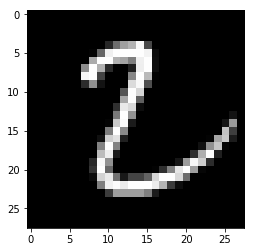

In [3]:
# First row is first image
image = train_data.data[np.random.randint(0, len(train_data.data))]

# h_train = h5py.File(test_data_file)
# image = np.array(h_train.get('ABNORMAL'))[156]

# Plot the image
plt.imshow(np.reshape(image, (28, 28)), cmap='gray')
plt.show()

## Define Model & Train

In [4]:
model_dir = './mnist_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

batch_size = 64
output_dimensions = 784
train_iters = 100000
plot_save_path = model_dir

model = RickAndMorty(batch_size=batch_size, 
                     output_dimensions=output_dimensions, 
                     train_iters=train_iters,
                     plot_save_path=plot_save_path)

detective = RickAndMortyDetective(
    model_configuration = {
        'model': model,
        'batch_size': batch_size,
        'output_dimensions': output_dimensions,
        'train_iters': train_iters,
        'save_path' : '{}/MNIST-abnormalclass-{}'.format(model_dir, abnormal_digit),
        'plot_save_path' : plot_save_path
    }
)

iter 0	time	0.6369976997375488	train disc cost	1.36696457862854
iter 1	time	0.11610865592956543	train disc cost	1.3392117023468018	train gen cost	0.6535652279853821
iter 2	time	0.061588287353515625	train disc cost	1.3293757438659668	train gen cost	0.628876805305481
iter 3	time	0.06166505813598633	train disc cost	1.3029053211212158	train gen cost	0.6262456178665161
iter 4	time	0.06981801986694336	train disc cost	1.2751649618148804	train gen cost	0.6174231767654419
iter 99	time	0.060404544127614875	train disc cost	0.3213968276977539	train gen cost	2.7173056602478027
iter 199	time	0.05491947889328003	train disc cost	0.002060496946796775	train gen cost	7.636897563934326
iter 299	time	0.057518653869628907	train disc cost	4.4468644773587584e-05	train gen cost	11.301734924316406
iter 399	time	0.05850240707397461	train disc cost	3.762510232263594e-06	train gen cost	13.65392780303955
iter 499	time	0.05453178644180298	train disc cost	1.7679731172393076e-06	train gen cost	14.381433486938477
iter 

iter 7499	time	0.059230198860168455	train disc cost	0.3268159031867981	train gen cost	3.057840347290039
iter 7599	time	0.05539808511734009	train disc cost	0.3291373550891876	train gen cost	2.9617843627929688
iter 7699	time	0.0586311149597168	train disc cost	0.3134278357028961	train gen cost	3.010951042175293
iter 7799	time	0.05754838228225708	train disc cost	0.3024543821811676	train gen cost	3.0716075897216797
iter 7899	time	0.05538048505783081	train disc cost	0.3181440830230713	train gen cost	3.1503233909606934
iter 7999	time	0.0594547176361084	train disc cost	0.30449429154396057	train gen cost	3.1416897773742676
iter 8099	time	0.05643426895141602	train disc cost	0.3030327558517456	train gen cost	3.1054821014404297
iter 8199	time	0.05591214895248413	train disc cost	0.2974482476711273	train gen cost	3.1615262031555176
iter 8299	time	0.05988985538482666	train disc cost	0.2898385524749756	train gen cost	3.250936508178711
iter 8399	time	0.05584170341491699	train disc cost	0.28820732235908

iter 15399	time	0.060225670337677	train disc cost	0.10926993191242218	train gen cost	4.973830699920654
iter 15499	time	0.056199548244476316	train disc cost	0.09868671745061874	train gen cost	5.319406032562256
iter 15599	time	0.05734686613082886	train disc cost	0.11152254045009613	train gen cost	5.148599624633789
iter 15699	time	0.06126322269439697	train disc cost	0.10044609010219574	train gen cost	5.133990287780762
iter 15799	time	0.05601394176483154	train disc cost	0.10003247112035751	train gen cost	5.267439365386963
iter 15899	time	0.058998613357543944	train disc cost	0.10012612491846085	train gen cost	5.329488754272461
iter 15999	time	0.05909443855285645	train disc cost	0.09040354937314987	train gen cost	5.3258209228515625
iter 16099	time	0.056112813949584964	train disc cost	0.10257520526647568	train gen cost	5.244393348693848
iter 16199	time	0.05964120388031006	train disc cost	0.09556889533996582	train gen cost	5.4784345626831055
iter 16299	time	0.05725640535354614	train disc cost	

iter 23199	time	0.05571202039718628	train disc cost	0.05450053513050079	train gen cost	6.800065517425537
iter 23299	time	0.06023855924606323	train disc cost	0.060919858515262604	train gen cost	6.989456653594971
iter 23399	time	0.05878605127334595	train disc cost	0.054032426327466965	train gen cost	6.752752304077148
iter 23499	time	0.056681201457977295	train disc cost	0.056401513516902924	train gen cost	6.762234687805176
iter 23599	time	0.06075728178024292	train disc cost	0.06694426387548447	train gen cost	6.8115129470825195
iter 23699	time	0.05782050848007202	train disc cost	0.053346361964941025	train gen cost	6.975454330444336
iter 23799	time	0.05747750759124756	train disc cost	0.054347243160009384	train gen cost	6.988488674163818
iter 23899	time	0.06108484983444214	train disc cost	0.06140100955963135	train gen cost	6.993188381195068
iter 23999	time	0.05660173654556275	train disc cost	0.04679102450609207	train gen cost	6.868924617767334
iter 24099	time	0.059182934761047364	train disc 

iter 30999	time	0.06151143789291382	train disc cost	0.057850681245326996	train gen cost	7.748203754425049
iter 31099	time	0.057668163776397705	train disc cost	0.05120950564742088	train gen cost	7.575933933258057
iter 31199	time	0.058622145652771	train disc cost	0.056380219757556915	train gen cost	7.6729936599731445
iter 31299	time	0.060978240966796875	train disc cost	0.05974952131509781	train gen cost	7.380704402923584
iter 31399	time	0.05689890384674072	train disc cost	0.04772166907787323	train gen cost	7.419435977935791
iter 31499	time	0.06063959836959839	train disc cost	0.054523129016160965	train gen cost	7.096466541290283
iter 31599	time	0.059536364078521725	train disc cost	0.05149288475513458	train gen cost	7.46163272857666
iter 31699	time	0.05695779800415039	train disc cost	0.048727381974458694	train gen cost	7.730654239654541
iter 31799	time	0.06106648683547974	train disc cost	0.04271567240357399	train gen cost	7.644455432891846
iter 31899	time	0.058275251388549804	train disc co

iter 38799	time	0.05715240955352783	train disc cost	0.04759305343031883	train gen cost	7.752485275268555
iter 38899	time	0.06177798509597778	train disc cost	0.038787856698036194	train gen cost	8.26596450805664
iter 38999	time	0.05930958032608032	train disc cost	0.04831722751259804	train gen cost	7.9622015953063965
iter 39099	time	0.05751232385635376	train disc cost	0.04485791549086571	train gen cost	7.719358921051025
iter 39199	time	0.0624448561668396	train disc cost	0.037472665309906006	train gen cost	8.077422142028809
iter 39299	time	0.05797072887420654	train disc cost	0.040600765496492386	train gen cost	7.958978176116943
iter 39399	time	0.05824328899383545	train disc cost	0.05448101833462715	train gen cost	7.926670551300049
iter 39499	time	0.06217986345291138	train disc cost	0.05596214905381203	train gen cost	7.541467666625977
iter 39599	time	0.05739632129669189	train disc cost	0.04850469529628754	train gen cost	7.983223915100098
iter 39699	time	0.060448198318481444	train disc cost	

iter 46599	time	0.061961896419525146	train disc cost	0.056854043155908585	train gen cost	8.194664001464844
iter 46699	time	0.05774597644805908	train disc cost	0.0659325122833252	train gen cost	7.523838043212891
iter 46799	time	0.059768543243408204	train disc cost	0.0535271018743515	train gen cost	7.96085262298584
iter 46899	time	0.06156683683395386	train disc cost	0.0657171756029129	train gen cost	7.973081111907959
iter 46999	time	0.0572147536277771	train disc cost	0.05588538199663162	train gen cost	8.074090957641602
iter 47099	time	0.061113975048065185	train disc cost	0.04500933736562729	train gen cost	8.07559585571289
iter 47199	time	0.059776456356048585	train disc cost	0.06002923473715782	train gen cost	8.468384742736816
iter 47299	time	0.057632312774658204	train disc cost	0.05696609616279602	train gen cost	7.842347621917725
iter 47399	time	0.06158632278442383	train disc cost	0.04396840184926987	train gen cost	8.283751487731934
iter 47499	time	0.058733367919921876	train disc cost	0.

iter 54399	time	0.057129230499267575	train disc cost	0.05699421092867851	train gen cost	8.304015159606934
iter 54499	time	0.06172321557998657	train disc cost	0.06699885427951813	train gen cost	8.225237846374512
iter 54599	time	0.05964808940887451	train disc cost	0.05048801749944687	train gen cost	8.221728324890137
iter 54699	time	0.057698941230773924	train disc cost	0.050341084599494934	train gen cost	8.46349811553955
iter 54799	time	0.06209240198135376	train disc cost	0.0548337921500206	train gen cost	8.368980407714844
iter 54899	time	0.05836524486541748	train disc cost	0.04541711509227753	train gen cost	8.515368461608887
iter 54999	time	0.059027111530303954	train disc cost	0.050345227122306824	train gen cost	8.418981552124023
iter 55099	time	0.06191844701766968	train disc cost	0.046755317598581314	train gen cost	8.657088279724121
iter 55199	time	0.057490766048431396	train disc cost	0.05231794714927673	train gen cost	8.262707710266113
iter 55299	time	0.06088992118835449	train disc cos

iter 62199	time	0.06204663753509521	train disc cost	0.045359186828136444	train gen cost	8.491857528686523
iter 62299	time	0.058066437244415285	train disc cost	0.05105890706181526	train gen cost	8.141051292419434
iter 62399	time	0.06007827043533325	train disc cost	0.051227569580078125	train gen cost	8.46060848236084
iter 62499	time	0.06128373384475708	train disc cost	0.03620053082704544	train gen cost	8.312928199768066
iter 62599	time	0.05729838609695435	train disc cost	0.06469912081956863	train gen cost	8.274333953857422
iter 62699	time	0.06115825653076172	train disc cost	0.04633138328790665	train gen cost	8.420707702636719
iter 62799	time	0.05982253551483154	train disc cost	0.04112296551465988	train gen cost	8.385353088378906
iter 62899	time	0.05869847297668457	train disc cost	0.048845067620277405	train gen cost	8.097216606140137
iter 62999	time	0.06199047803878784	train disc cost	0.04885468631982803	train gen cost	8.093132019042969
iter 63099	time	0.05888362646102905	train disc cost	

iter 69999	time	0.05810755729675293	train disc cost	0.05057686194777489	train gen cost	8.257098197937012
iter 70099	time	0.06185604333877563	train disc cost	0.07743608206510544	train gen cost	8.74960708618164
iter 70199	time	0.05934407234191894	train disc cost	0.05624343827366829	train gen cost	8.28554630279541
iter 70299	time	0.0588726544380188	train disc cost	0.052939534187316895	train gen cost	8.250092506408691
iter 70399	time	0.06206067800521851	train disc cost	0.047278083860874176	train gen cost	8.483141899108887
iter 70499	time	0.058980329036712645	train disc cost	0.047403484582901	train gen cost	8.273994445800781
iter 70599	time	0.05972310781478882	train disc cost	0.05420122295618057	train gen cost	8.361992835998535
iter 70699	time	0.061611926555633544	train disc cost	0.08666572719812393	train gen cost	8.583666801452637
iter 70799	time	0.05774495840072632	train disc cost	0.058768801391124725	train gen cost	8.259468078613281
iter 70899	time	0.06104351043701172	train disc cost	0.0

iter 77799	time	0.06211543083190918	train disc cost	0.0602165088057518	train gen cost	8.025232315063477
iter 77899	time	0.0580134129524231	train disc cost	0.05294095352292061	train gen cost	8.427491188049316
iter 77999	time	0.06063026666641235	train disc cost	0.041076671332120895	train gen cost	8.54239273071289
iter 78099	time	0.061284170150756836	train disc cost	0.06608495861291885	train gen cost	8.240306854248047
iter 78199	time	0.05762434244155884	train disc cost	0.05697930231690407	train gen cost	8.384051322937012
iter 78299	time	0.06116818904876709	train disc cost	0.0513550266623497	train gen cost	8.44106674194336
iter 78399	time	0.06008769035339356	train disc cost	0.057172585278749466	train gen cost	8.554817199707031
iter 78499	time	0.057926902770996096	train disc cost	0.05379379913210869	train gen cost	8.308226585388184
iter 78599	time	0.06196760654449463	train disc cost	0.060884710401296616	train gen cost	8.194687843322754
iter 78699	time	0.05856633901596069	train disc cost	0.0

iter 85599	time	0.058346800804138184	train disc cost	0.07094787806272507	train gen cost	8.584909439086914
iter 85699	time	0.06190730094909668	train disc cost	0.059507664293050766	train gen cost	8.30859375
iter 85799	time	0.05947282552719116	train disc cost	0.06195792555809021	train gen cost	8.178313255310059
iter 85899	time	0.05872529745101929	train disc cost	0.05725807324051857	train gen cost	8.564419746398926
iter 85999	time	0.0621033501625061	train disc cost	0.06053979694843292	train gen cost	8.545377731323242
iter 86099	time	0.05820647954940796	train disc cost	0.056371837854385376	train gen cost	8.523083686828613
iter 86199	time	0.060618233680725095	train disc cost	0.06050492450594902	train gen cost	8.309688568115234
iter 86299	time	0.06177417039871216	train disc cost	0.06117375195026398	train gen cost	8.266075134277344
iter 86399	time	0.05769418478012085	train disc cost	0.05421743914484978	train gen cost	8.239606857299805
iter 86499	time	0.06186697721481323	train disc cost	0.06702

iter 93399	time	0.06215585231781006	train disc cost	0.054739270359277725	train gen cost	8.645306587219238
iter 93499	time	0.057794573307037356	train disc cost	0.05707916244864464	train gen cost	8.460670471191406
iter 93599	time	0.06091455221176147	train disc cost	0.05706426501274109	train gen cost	8.150036811828613
iter 93699	time	0.06154529571533203	train disc cost	0.055264104157686234	train gen cost	8.564026832580566
iter 93799	time	0.05755816698074341	train disc cost	0.05774092301726341	train gen cost	8.510872840881348
iter 93899	time	0.0616815447807312	train disc cost	0.06807693839073181	train gen cost	7.7264533042907715
iter 93999	time	0.05964998960494995	train disc cost	0.05741018429398537	train gen cost	8.387153625488281
iter 94099	time	0.058178653717041014	train disc cost	0.058079104870557785	train gen cost	8.510475158691406
iter 94199	time	0.06281847476959229	train disc cost	0.06171701103448868	train gen cost	8.383903503417969
iter 94299	time	0.0585294508934021	train disc cost

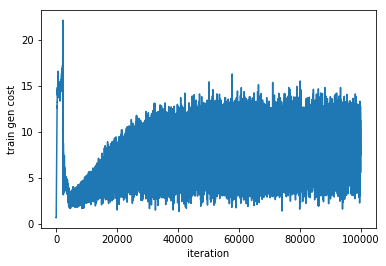

In [5]:
# detective.train(train_data)

## Evaluate Results

### Load trained model

In [6]:
# detective = RickAndMortyDetective(model_configuration={
#     'model': model,
#     'batch_size': batch_size,
#     'output_dimensions': output_dimensions,
#     'train_iters': train_iters,
#     'load_path' : '{}/MNIST-abnormalclass-{}'.format(model_dir, abnormal_digit),
#     'plot_save_path' : plot_save_path
# })

### Visualise generated samples

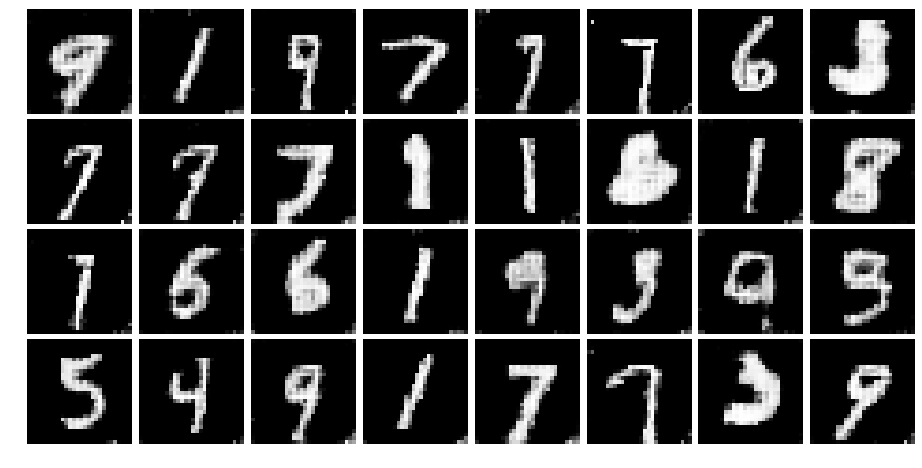

In [6]:
n_row = 4
n_col = 8

plt.figure(figsize=(2*n_col, 2*n_row))

gs = gridspec.GridSpec(n_row, n_col)
gs.update(wspace=0.025, hspace=0.05)

generated_samples = detective.model.fake_chunks_image()

for i in range(n_row * n_col):
    ax = plt.subplot(gs[i])
    ax.axis('off')
    ax.imshow(generated_samples[i], cmap='gray')

### Load test data


In [7]:
# Get test data
test_data_normal = test_data_source.get_train_data('NORMAL')
test_data_abnormal = test_data_source.get_train_data('ABNORMAL')
test_data = test_data_source.get_train_data('ALL')

# Ground truth for ABNORMAL data is 0, ground truth for NORMAL data is 1
n1 = np.zeros(len(test_data_abnormal.data))
n2 = np.ones(len(test_data_normal.data))
expected_truth = np.hstack((n1, n2))

### Calculate ROC Score

In [8]:
detection_result = detective.detect(test_data)

roc_score = GANPerformanceAnalysis({}).analyse(
  detection_result=detection_result.data,
  expected_truth=expected_truth
)

print('ROC Score: {}'.format(roc_score))

ROC Score: 0.4357545112910554


### Generate classification report

In [9]:
train_results = detective.detect(train_data).data
threshold = np.mean(train_results)
prediction = [1 if x >= threshold else 0 for x in detection_result.data]

target_names = ['ABNORMAL', 'NORMAL']
print(classification_report(expected_truth, prediction, target_names=target_names))

              precision    recall  f1-score   support

    ABNORMAL       0.32      0.50      0.39      6903
      NORMAL       0.61      0.43      0.51     12620

   micro avg       0.46      0.46      0.46     19523
   macro avg       0.47      0.47      0.45     19523
weighted avg       0.51      0.46      0.47     19523



## Root Cause Analysis

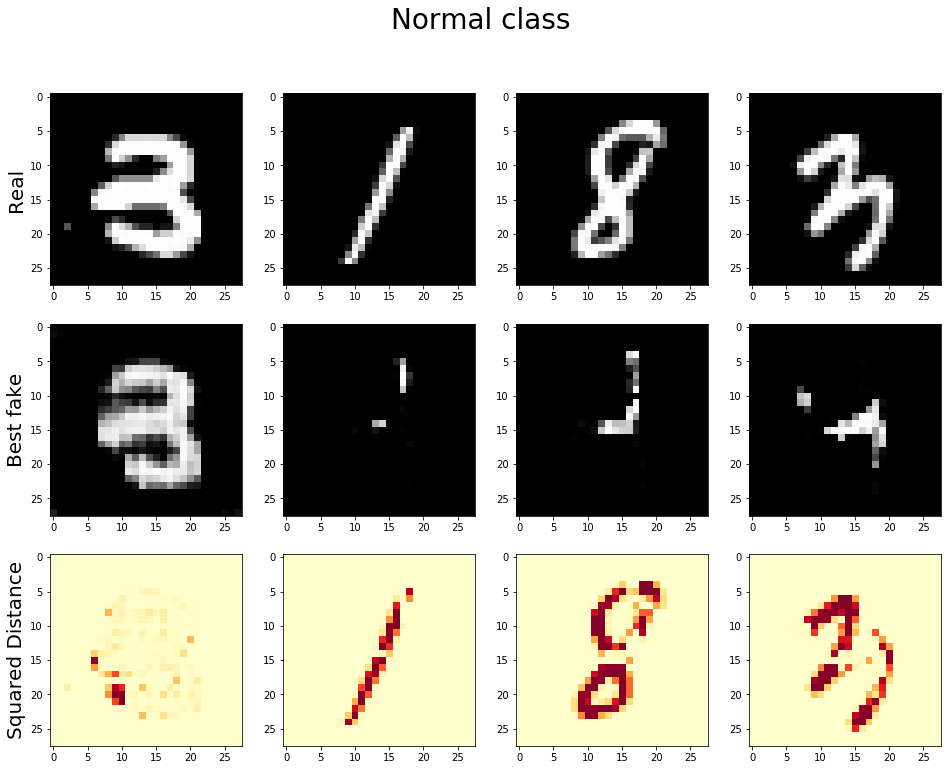

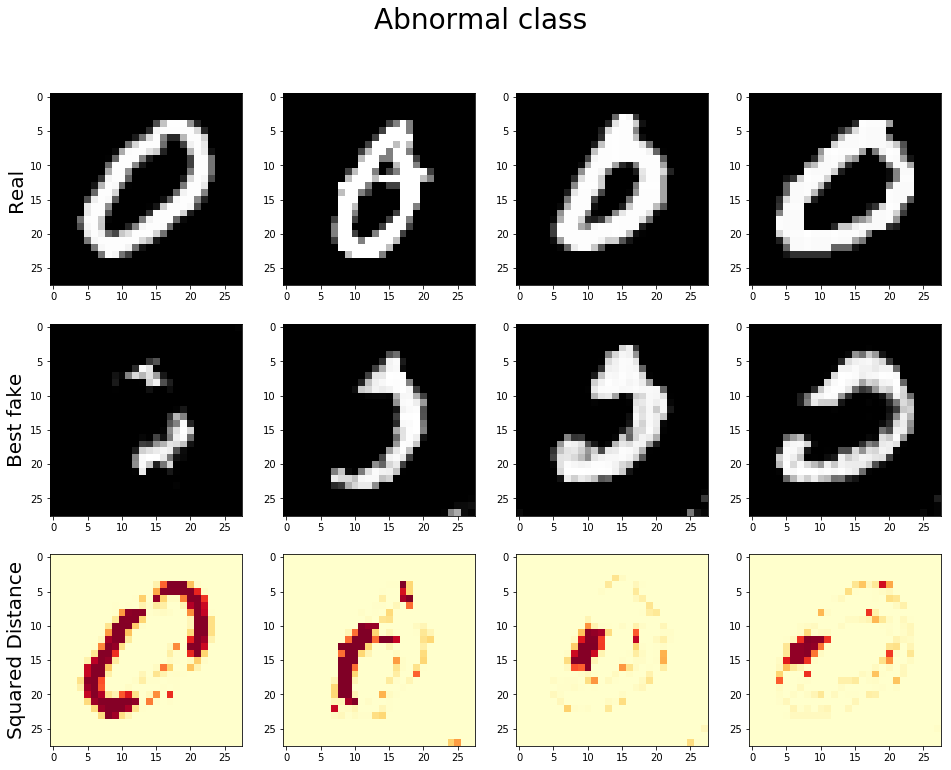

In [10]:
n_img = 4

normal_test_images = \
    test_data_normal.data[np.random.choice(test_data_normal.data.shape[0], n_img, replace=False), :, :]
abnormal_test_images = \
    test_data_abnormal.data[np.random.choice(test_data_abnormal.data.shape[0], n_img, replace=False), :, :]

normal_best_fakes = [detective.diagnose(nor_img) for nor_img in normal_test_images]
abnormal_best_fakes = [detective.diagnose(abn_img) for abn_img in abnormal_test_images]

# Plot normal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Normal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(normal_test_images[i], cmap='gray'); 
    ax[1, i].imshow(normal_best_fakes[i], cmap='gray')
    ax[2, i].imshow(np.square(normal_test_images[i] - normal_best_fakes[i]), cmap='YlOrRd', vmin=0, vmax=1)

# Plot abnormal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Abnormal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(abnormal_test_images[i], cmap='gray'); 
    ax[1, i].imshow(abnormal_best_fakes[i], cmap='gray')
    ax[2, i].imshow(np.square(abnormal_test_images[i] - abnormal_best_fakes[i]), cmap='YlOrRd', vmin=0, vmax=1)